# Chapter 5: Extra code, drafts, and cut material

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Beta-binomial demos

In [2]:
from scipy.special import binom, betaln

def beta_binom(prior, y):
    """
    Compute the marginal-log-likelihood for a beta-binomial model,
    analytically.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    α, β = prior
    success = np.sum(y)
    trials = len(y)
    return np.log(binom(trials, success)) + betaln(α + success, β+trials-success) - betaln(α, β)

In [3]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior

In [4]:
def normal_harmonic(sd_0, sd_1, y, s=10000):
    post_tau = 1/sd_0**2 + 1/sd_1**2
    posterior_samples = stats.norm(loc=(y/sd_1**2)/post_tau, scale=(1/post_tau)**0.5).rvs((s, len(x)))
    log_likelihood = stats.norm.logpdf(loc=x, scale=sd_1, x=posterior_samples).sum(1)
    return 1/np.mean(1/log_likelihood)

In [5]:
from scipy import stats
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [6]:
def posterior_ml_ic_normal(σ_0=1, σ_1=1, y=[1]):
    n = len(y)
    var_μ = 1/((1/σ_0**2) + (n/σ_1**2))
    μ = var_μ * np.sum(y)/σ_1**2
    σ_μ = var_μ**0.5

    posterior = stats.norm(loc=μ, scale=σ_μ)
    samples = posterior.rvs(size=(2, 1000))
    log_likelihood = stats.norm(loc=samples[:, :, None], scale=σ_1).logpdf(y)
    idata = az.from_dict(log_likelihood={'o': log_likelihood})

    log_ml = stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()
    
    x = np.linspace(-5, 6, 300)
    density = posterior.pdf(x)
    
    return μ, σ_μ, x, density, log_ml, az.waic(idata).elpd_waic, az.loo(idata, reff=1).elpd_loo

Text(0.5, 0, 'μ')

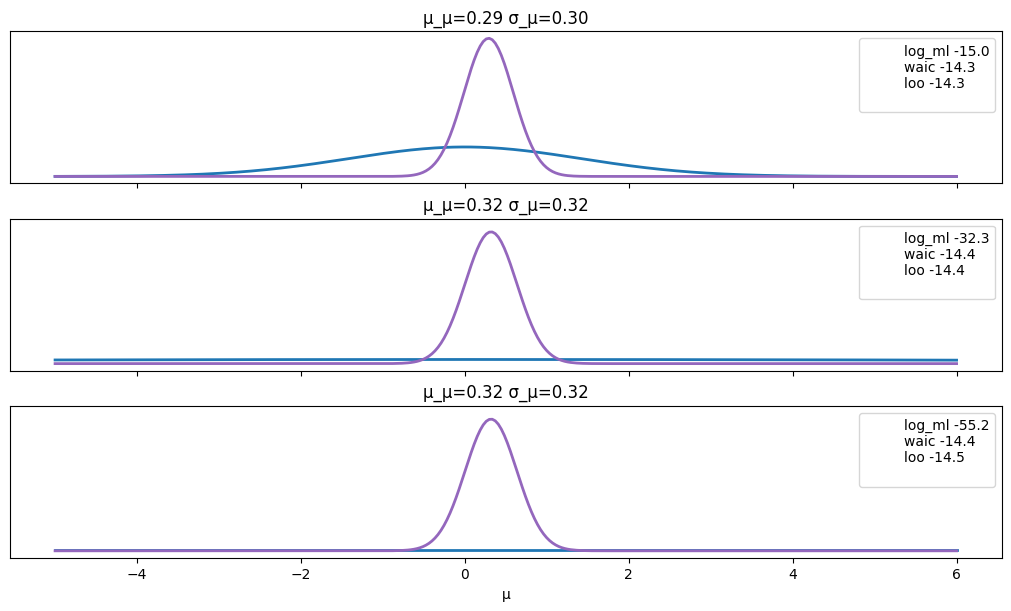

In [7]:
import arviz as az

y = np.array([ 0.65225338, -0.06122589,  0.27745188,  1.38026371, -0.72751008,
              -1.10323829,  2.07122286, -0.52652711,  0.51528113,  0.71297661])

_, ax = plt.subplots(3, figsize=(10, 6), sharex=True, sharey=True,
                     constrained_layout=True)

for i, σ_0 in enumerate((1, 10, 100)):
    μ_μ, σ_μ, x, density, log_ml, waic, loo = posterior_ml_ic_normal(σ_0, σ_1, y)
    ax[i].plot(x, stats.norm(loc=0, scale=(σ_0**2+σ_1**2)**0.5).pdf(x), lw=2)
    ax[i].plot(x, density, lw=2, color='C4')
    ax[i].plot(0, label=f'log_ml {log_ml:.1f}\nwaic {waic:.1f}\nloo {loo:.1f}\n', alpha=0)
    ax[i].set_title(f'μ_μ={μ_μ:.2f} σ_μ={σ_μ:.2f}')
    ax[i].legend()
ax[2].set_yticks([])

ax[2].set_xlabel("μ")

#plt.savefig("img/chp11/ml_waic_loo.png")

In [8]:
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2 + σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [9]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior

## Bayesian p-value

In [10]:
import pymc as pm
import numpy as np
import arviz as az

# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

# Bayesian Linear Regression Model
with pm.Model() as model:
    # Priors
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Likelihood
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [11]:
# Posterior Predictive Check
# with model:
#     ppc = pm.sample_posterior_predictive(trace)    
# Posterior Predictive Check
ppc = pm.sample_posterior_predictive(trace, model=model)
    


Sampling: [y_obs]


Output()

In [12]:
# Extract the posterior predictive samples for 'y_obs'
y_rep = ppc.posterior_predictive["y_obs"].values

# Calculate Bayesian p-value for the slope
test_stat_observed = np.mean(y)  # Example test statistic
test_stat_rep = np.mean(y_rep, axis=1)
bayesian_p_value = np.mean(test_stat_rep >= test_stat_observed)
print("Bayesian p-value:", bayesian_p_value)

Bayesian p-value: 0.4925


In [13]:
# manual numerical integral function to check posterior is well normalized
def myint(xs, ys):
    delta = xs[1] - xs[0]
    return np.sum(ys) * delta

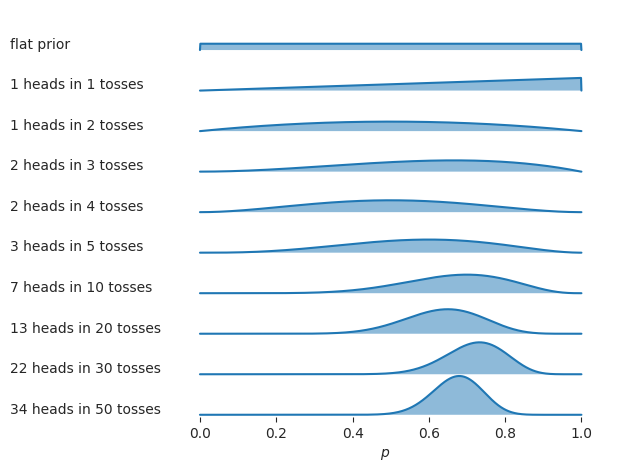

In [14]:
# FIGURES ONLY
# Inspired by  https://python-graph-gallery.com/ridgeline-graph-seaborn/
from scipy.stats import beta



n_rows = 10
ns =       [0, 1, 2, 3, 4, 5, 10, 20, 30,  50]
outcomes = [0, 1, 1, 2, 2, 3,  7, 13, 22,  34]
# outcomes were generated from coin with true p = 0.7
assert len(outcomes) == n_rows
assert len(ns) == n_rows
n_rows = int(len(outcomes))

dists = pd.DataFrame({
    "case": range(n_rows),
    "n": ns,
    "outcome": outcomes,
})

labels = []
for i in range(n_rows):
    heads, n = outcomes[i], ns[i]
    if i==0:
        label = "flat prior"
    else:
        label = f"{heads} heads in {n} tosses"
    labels.append(label)


def plot_case(heads, n, *args, **kwargs):
    rvPpost = beta(a=1+heads, b=1+n-heads)
    eps = 0.001
    ps = np.linspace(0-eps, 1.0+eps, 1000)
    rvPpdf = rvPpost.pdf(ps)
    ax = sns.lineplot(x=ps, y=rvPpdf, alpha=1)
    ax.fill_between(ps, 0, rvPpdf, alpha=0.5)

with sns.axes_style("white"), plt.rc_context({"axes.facecolor": (0, 0, 0, 0), "xtick.bottom":True}):
    g = sns.FacetGrid(dists, row='case', aspect=12, height=0.5)
    g.map(plot_case, "outcome", "n")
    
    # add labels on the left
    for i, ax in enumerate(g.axes.flat):
        ax.text(-0.5, 0.3, labels[i], fontsize=10, ha="left", multialignment="right")

    # adjust spacing to get the axes to overlap
    g.fig.subplots_adjust(hspace=-0.05)

    # other figure cleanup
    g.set(xlim=[-0.3,1.1])
    g.set(xticks=np.linspace(0,1,6))
    for i, ax in enumerate(g.axes.flat):
        if i != n_rows-1:
            # remove x-ticks (except for last)
            ax.tick_params(bottom=False)
    g.set(xlabel="               $p$")
    g.set_titles(template="")
    g.set(yticks=[])
    g.set(ylabel=None)
    g.despine(bottom=True, left=True)

    # save as PDF and PNG
    # filename = os.path.join(DESTDIR, "ridgeplot_coin_posteriors.pdf")
    # fig = plt.gcf()
    # fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
    # filename2 = filename.replace(".pdf", ".png")
    # fig.savefig(filename2, dpi=300, bbox_inches="tight", pad_inches=0)
    # print("Saved figure to", filename)    
    # print("Saved figure to", filename2)

### Maximum a posteriori estimates

In [15]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

iqs_out = iqs.copy()
iqs_out[0] = 300
iqs_out[1] = 300
np.mean(iqs_out)

121.55333333333334

In [16]:
# ML
from scipy.stats import norm

muso = np.linspace(-100, 300, 100001)
sigma = 15
likelihood2o = np.ones(100001)
for iq_out in iqs_out:
    likelihood_iq_out = norm(loc=muso, scale=sigma).pdf(iq_out)
    likelihood2o = likelihood2o * likelihood_iq_out

mu_ML = muso[np.argmax(likelihood2o)]
print(mu_ML)

121.55199999999999


In [17]:
# MAP
prior2o = norm(loc=100, scale=10).pdf(muso)
numerator2o = likelihood2o * prior2o
posterior2o = numerator2o / np.sum(numerator2o)

# posterior mode 
muso[np.argmax(posterior2o)]

120.048

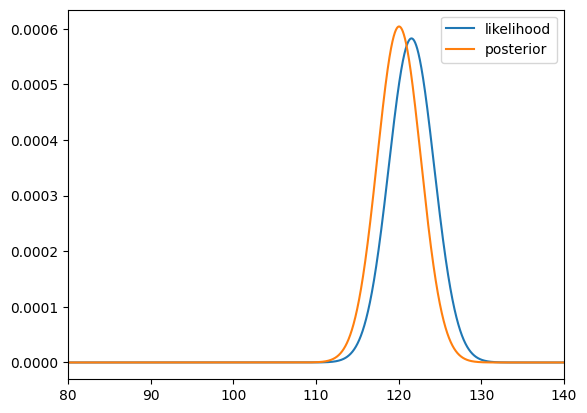

In [18]:
ax = sns.lineplot(x=muso, y=likelihood2o/np.sum(likelihood2o), label="likelihood")
sns.lineplot(x=muso, y=posterior2o/np.sum(posterior2o), ax=ax, label="posterior")
ax.set_xlim([80,140]);

### Example 1 using PyMC

In [19]:
import pandas as pd
import pymc as pm


ctosses = pd.read_csv("../datasets/exercises/ctosses.csv")

with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    P = pm.Beta("P", alpha=1, beta=1)
    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=P, observed=ctosses)
    # Sample from the posterior distribution
    idata1_alt = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [20]:
pred_dists1 = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata1_alt, model).posterior_predictive["y_obs"].values)

Sampling: [P, y_obs]
Sampling: [y_obs]


Output()

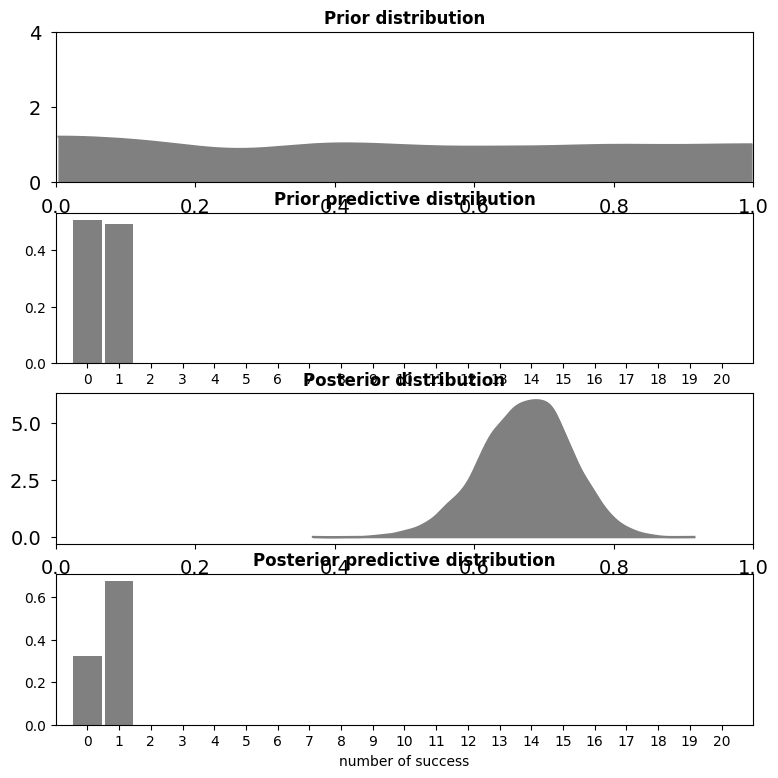

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists1):
    az.plot_dist(dist.sum(-1), 
                 hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                 ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution", fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(P, 1000),
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("p")

az.plot_dist(idata1_alt.posterior["P"],
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1},
             ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("p");

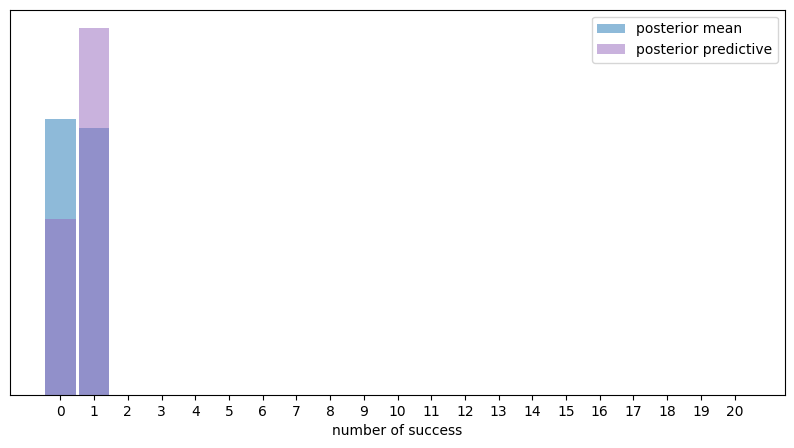

In [22]:
# ???
from scipy.stats import binom
predictions1 = (binom(n=1, p=idata1_alt.posterior["P"].mean()).rvs((4000, len(ctosses))),
               pred_dists1[1])
for d, c, l in zip(pred_dists1, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(-1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")

### Verify IQ computation against the R package `BayesFactor`

In [23]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

import rpy2.robjects as robjects
from rpy2.robjects import r as runr, pandas2ri
from rpy2.robjects.packages import importr
pandas2ri.activate()

# import the BayesFactor package
BayesFactor = importr('BayesFactor')

# copy the data sample into the R workspace
robjects.globalenv["iqs"] = np.array(iqs)

# compute the Bayes factor
runr('bf = ttestBF(iqs, mu=100)')
runr('print(bf)')

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 3.739463 ±0%

Against denominator:
  Null, mu = 100 
---
Bayes factor type: BFoneSample, JZS



In [24]:
# ALT. likelihood calculations for Example 1 in Sec 5.1
ngrid1 = 101             # number of points in the grid
ps = np.linspace(0, 1, ngrid1) # [0, 0.01, ..., 1.0]

ctosses = [1,1,0,0,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,1,
           1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,
           0,1,0,1,0,1,0,1,1,0]

from scipy.stats import bernoulli
likelihood1 = np.ones(ngrid1)
for ctoss in ctosses:
    likelihood_ctoss = bernoulli(p=ps).pmf(ctoss)
    likelihood1 = likelihood1 * likelihood_ctoss


# ALT2:
# np.prod(bernoulli(p=ps[:,np.newaxis]).pmf(ctosses), axis=1)

# likelihood1[0:101:25]
list(map(lambda x: float("{:1.3g}".format(x)), likelihood1[0:101:25]))

[0.0, 3.4e-23, 8.88e-16, 1.32e-14, 0.0]

In [25]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

ngrid2 = 1001  # number of points in the grid
mus = np.linspace(80, 120, ngrid2)

# ALT. one-line computation using NumPy broadcasting rules
likelihood2 = np.prod(norm(loc=mus[:,np.newaxis], scale=15).pdf(iqs), axis=1)
likelihood2[0:1001:300]

array([1.23613569e-77, 1.80497559e-62, 1.20898934e-55, 3.71466415e-57])

### ALT stuff form Sec 5.2

In [26]:
# ALT. load the `ctosses` data frame from the exercises/ folder
df1 = pd.read_csv("../datasets/exercises/ctosses.csv")
# df1.head()

In [27]:
# BONUS DEMO: simulate a random sample from the model

# params
n = len(df1)
true_p = 0.7

# gen a random data frame DF1 like df1
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_p).rvs(n)
DF1 = pd.DataFrame({"heads": ctosses})
DF1["heads"].values, DF1["heads"].mean()

(array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1]),
 0.8)

In [28]:
# BONUS DEMO 2: simulate a random sample from the prior predictive distribution
# np.random.seed(47)
n = len(df1)

# gen parameters p independently for each observation
from scipy.stats import uniform
true_ps = uniform(0,1).rvs(n)

# gen a random data sample of size n
from scipy.stats import bernoulli
ctosses = bernoulli(p=true_ps).rvs(n)
DF1 = pd.DataFrame({"ctoss": ctosses})
DF1["ctoss"].values, DF1["ctoss"].mean()

(array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1]),
 0.48)

In [29]:
# ALT. load the `iqs.csv` data file from the exercises/ folder
iqs = pd.read_csv("../datasets/exercises/iqs.csv")
iqs["iq"].mean()

107.82333333333334

In [30]:
import bambi as bmb

priors2 = {
    "Intercept": bmb.Prior("Normal", mu=100, sigma=40),
    "sigma": bmb.Prior("Data", value=15),
    # "sigma": 15,  # CHANGE WHEN https://github.com/bambinos/bambi/pull/851/files LANDS
}

mod2 = bmb.Model(formula="iq ~ 1",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=iqs)

mod2.set_alias({"Intercept":"M"})
mod2.build()
mod2

       Formula: iq ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 30
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 100.0, sigma: 40.0)
        
        Auxiliary parameters
            sigma ~ Data(value: 15.0)

In [31]:
# Inspect different types of variables in the model
mod2.backend.model.data_vars, \
mod2.backend.model.observed_RVs, \
mod2.backend.model.unobserved_RVs

([sigma], [iq], [M, mu])

### Choice of priors

Different priors lead to different posteriors.

See `Code 1.8 and Figure 1.7` in
[chp_01.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_01.ipynb)

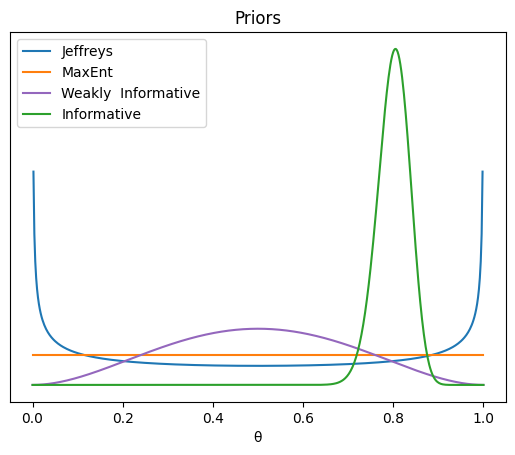

In [32]:
from scipy.stats import beta

x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys",
          "MaxEnt",
          "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}")
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()
# plt.savefig("img/chp01/prior_informativeness_spectrum.png")

In [33]:
# Bayes factors: plot of Savage-Dickey density ratio
# idata_prior = mod2.prior_predictive()
# idata2.add_groups({"prior":idata_prior["prior"]})
# az.plot_bf(idata2, var_name="M", ref_val=100)

### Alternative for extracting the samples from the posterior

Another option is to use the method `.stack` on the `DataArray`
to combine the `chain` and `draw` indices.
The overall procedure has four steps:

1. select the group `"posterior"`
2. select the variable `P`
3. combine the `chain` (0...3) and `draw` (0...999) indices into a single index `sample` (0...3999)
4. extract the actual values

In [34]:
# ALT. manually extract the samples from the posterior
idata1 = idata1_alt
postP = (idata1["posterior"]                     # (1) 
               ["P"]                             # (2)
               .stack(sample=("chain", "draw"))  # (3)
               .values)                          # (4)
postP

array([0.66559938, 0.67951482, 0.67719431, ..., 0.6565611 , 0.68574659,
       0.70048767])

### Debugging and detailed printing

In [35]:
mod2.backend.model

In [36]:
from pymc.printing import str_for_dist, str_for_model, str_for_potential_or_deterministic
print(str_for_model(mod2.backend.model))

 M ~ Normal(100, 40)
mu ~ Deterministic(f(M))
iq ~ Normal(mu, 15)


In [37]:
# DEBUG INFO
import pytensor

with mod2.backend.model:
    # Retrieve the deterministic variable
    deterministic_var = mod2.backend.model['mu']  # Replace 'p' with the actual name of your deterministic variable

    # Print the details of the deterministic variable
    print(deterministic_var)
    print(deterministic_var.type)
    pytensor.printing.debugprint(deterministic_var)
    print(str_for_potential_or_deterministic(deterministic_var))

mu
Vector(float64, shape=(30,))
Identity [id A] 'mu'
 └─ Add [id B]
    ├─ ExpandDims{axis=0} [id C]
    │  └─ 0 [id D]
    └─ Mul [id E]
       ├─ ExpandDims{axis=0} [id F]
       │  └─ normal_rv{"(),()->()"}.1 [id G] 'M'
       │     ├─ RNG(<Generator(PCG64) at 0x306C23BC0>) [id H]
       │     ├─ NoneConst{None} [id I]
       │     ├─ 100.0 [id J]
       │     └─ 40.0 [id K]
       └─ [1. 1. 1. ... 1. 1. 1.] [id L]
mu ~ Deterministic(f(M))


## Example 1: eight schools

cf. centered non-centered example in NumPyro
https://github.com/pyro-ppl/numpyro?tab=readme-ov-file#a-simple-example---8-schools


In [38]:
J = 8
ys = [28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]
sigmas = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]

schools = pd.DataFrame({"school":range(1,J+1),
                        "y":ys,
                        "sigma":sigmas})

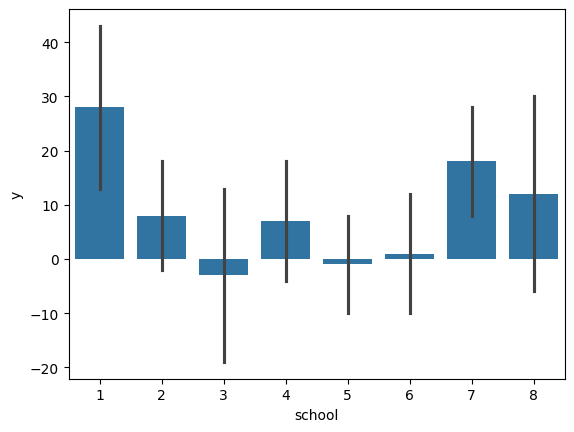

In [39]:
# ALT. bar-plot using plt
# plt.bar(range(J), ys, yerr=sigmas);

# duplicate schools to trigger the errorbar logic in `sns.barplot`
dblschools = pd.concat([schools,schools])

def errorbar4y(y):
    """
    Custom function to draw error bar taken from the `sigma` column.
    """
    yval = y.values[0]
    sigma = schools[schools["y"]==yval]["sigma"]
    return (yval-sigma, yval+sigma)

sns.barplot(x="school", y="y", errorbar=errorbar4y, data=dblschools);